In [1]:
import os
os.chdir('../')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from src import milan, milannotations
from src.exemplars.models import default_model_configs
from src.exemplars.models import load

In [3]:
alexnet_imagenet = milannotations.load('alexnet/imagenet')

load alexnet/imagenet: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.43s/it]


In [260]:
len(alexnet_imagenet.samples_by_layer_unit.keys())

1152

In [ ]:
alexnet_imagenet.samples_by_layer_unit[('layer4', 0)].annotations

In [85]:
key_lst = [key for key in alexnet_imagenet.samples_by_layer_unit.keys() if key[0] == 'conv1']
sorted(key_lst, key = lambda x: x[1])

[('conv1', 0),
 ('conv1', 1),
 ('conv1', 2),
 ('conv1', 3),
 ('conv1', 4),
 ('conv1', 5),
 ('conv1', 6),
 ('conv1', 7),
 ('conv1', 8),
 ('conv1', 9),
 ('conv1', 10),
 ('conv1', 11),
 ('conv1', 12),
 ('conv1', 13),
 ('conv1', 14),
 ('conv1', 15),
 ('conv1', 16),
 ('conv1', 17),
 ('conv1', 18),
 ('conv1', 19),
 ('conv1', 20),
 ('conv1', 21),
 ('conv1', 22),
 ('conv1', 23),
 ('conv1', 24),
 ('conv1', 25),
 ('conv1', 26),
 ('conv1', 27),
 ('conv1', 28),
 ('conv1', 29),
 ('conv1', 30),
 ('conv1', 31),
 ('conv1', 32),
 ('conv1', 33),
 ('conv1', 34),
 ('conv1', 35),
 ('conv1', 36),
 ('conv1', 37),
 ('conv1', 38),
 ('conv1', 39),
 ('conv1', 40),
 ('conv1', 41),
 ('conv1', 42),
 ('conv1', 43),
 ('conv1', 44),
 ('conv1', 45),
 ('conv1', 46),
 ('conv1', 47),
 ('conv1', 48),
 ('conv1', 49),
 ('conv1', 50),
 ('conv1', 51),
 ('conv1', 52),
 ('conv1', 53),
 ('conv1', 54),
 ('conv1', 55),
 ('conv1', 56),
 ('conv1', 57),
 ('conv1', 58),
 ('conv1', 59),
 ('conv1', 60),
 ('conv1', 61),
 ('conv1', 62),
 (

In [136]:
data_dir = '/cis/project/vision_sequences/ImageNet-ImageFolderFormat/'
batch_size = 16

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])
image_transform = transforms.Compose([
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])
testset = datasets.ImageFolder(
    f'{data_dir}/val/',
    transform=test_transforms
)
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    drop_last=True,
    pin_memory=True,
    num_workers=4
)

In [29]:
X_test, y_test = next(iter(testloader))

In [262]:
def get_output(layer):
    def hook(model, input, output):
        layer_outputs[layer] = output
    return hook

model, layer, config = load('alexnet/imagenet', pretrained=True)
model.eval()

layer_hooks, layer_outputs = {}, {}
for hook_idx, layer_idx, layer_name in zip(range(5), [1, 4, 7, 9, 11], ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']):
    layer_hook = model[layer_idx].register_forward_hook(get_output(layer_name))
    layer_hooks[hook_idx] = layer_hook

In [254]:
act_quant = utils.load_json(os.path.join('./activations/alexnet_imagenet/quantiles99.json'))
act_quant = {_key: torch.tensor(_values) for _key, _values in act_quant.items()}
dd

{'conv1': tensor([26.8815, 10.2355, 39.7814, 30.9963, 39.3487, 27.9759, 24.0859, 15.1226,
         10.4946, 29.2485, 25.9497, 29.2645, 31.0958, 33.1620, 24.6965, 16.8495,
         32.7649, 23.2365, 31.1839, 17.5083, 38.4701, 30.1081, 30.1245, 31.7752,
         30.7458, 30.0558, 26.6738, 31.2627, 31.3240, 24.2833, 31.2365, 21.9355,
         23.5940, 28.3564, 26.9909, 19.1767,  9.2723, 31.5426, 30.0563, 18.9106,
         15.6736, 32.8283, 33.9367, 26.7632, 31.5063, 24.6343, 14.0125, 25.9230,
         27.9759, 36.5203, 27.5150,  9.8784, 15.3041,  8.9599, 30.6270, 29.2562,
         28.5469, 32.0027, 13.9970, 31.1188, 12.7140, 25.5318, 23.4239, 25.7329]),
 'conv2': tensor([ 55.5824,  62.1346,  54.2364,  27.4943,  33.9996,  31.5589,  71.0274,
          25.3839,  47.8278,  53.9054,  27.5202, 110.6819,  50.6355,  31.8878,
          30.2576,  33.6094,  35.7860,  29.3074,   6.9546,  33.4673,  24.9640,
          49.9321,  74.1564,  40.9692,  48.3560,  45.8753,  65.5656,  45.7621,
          25.429

In [263]:
n_units = {
        'conv1': 64,
        'conv2': 192,
        'conv3': 384,
        'conv4': 256,
        'conv5': 256
}

max_act_vals = {
        'conv1': [],
        'conv2': [],
        'conv3': [],
        'conv4': [],
        'conv5': []
}

In [264]:
for i, sample in enumerate(alexnet_imagenet.samples):
    images_transformed = image_transform(sample.images * sample.masks)

    logits = model(images_transformed)

    for _layer in alexnet_imagenet.layers:
        max_act_vals[_layer].append(layer_outputs[_layer].flatten(2, 3).max(-1).values)

    print(i, end=' '')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [265]:
quantiles_per_layer = {}

for layer in alexnet_imagenet.layers:
    quantiles_per_layer[layer] = torch.quantile(
        torch.cat(max_act_vals[layer], dim=0),
        0.90,
        dim=0
    ).tolist()

In [266]:
import utils
import json

path = './activations/alexnet_imagenet/'
os.makedirs(path, exist_ok=True)
with open(os.path.join(path, 'quantiles90.json'), 'w') as f:
    json.dump(quantiles_per_layer, f, indent=2, sort_keys=True)

In [168]:
for sample_i in range(15):
    for channel_i in range(10):
        print(layer_outputs['conv5'][sample_i, channel_i].max())
    print()
    print()

tensor(7.1823, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MaxBackward1>)
tensor(9.7323, grad_fn=<MaxBackward1>)
tensor(1.4836, grad_fn=<MaxBackward1>)
tensor(2.3803, grad_fn=<MaxBackward1>)
tensor(13.7437, grad_fn=<MaxBackward1>)
tensor(2.8625, grad_fn=<MaxBackward1>)
tensor(22.6715, grad_fn=<MaxBackward1>)
tensor(1.9748, grad_fn=<MaxBackward1>)
tensor(7.1726, grad_fn=<MaxBackward1>)


tensor(2.7452, grad_fn=<MaxBackward1>)
tensor(1.4496, grad_fn=<MaxBackward1>)
tensor(8.9062, grad_fn=<MaxBackward1>)
tensor(5.2130, grad_fn=<MaxBackward1>)
tensor(4.6757, grad_fn=<MaxBackward1>)
tensor(0.4328, grad_fn=<MaxBackward1>)
tensor(7.0445, grad_fn=<MaxBackward1>)
tensor(15.8531, grad_fn=<MaxBackward1>)
tensor(16.4455, grad_fn=<MaxBackward1>)
tensor(3.8235, grad_fn=<MaxBackward1>)


tensor(1.3843, grad_fn=<MaxBackward1>)
tensor(3.1632, grad_fn=<MaxBackward1>)
tensor(18.9758, grad_fn=<MaxBackward1>)
tensor(2.6375, grad_fn=<MaxBackward1>)
tensor(1.2087, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<

In [104]:
layer_outputs['conv1'][sample_i].shape

torch.Size([64, 55, 55])

In [73]:
decoder = milan.pretrained('base')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324M/324M [00:05<00:00, 63.8MB/s]
/cis/home/kchan49/anaconda3/envs/neuron/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/cis/home/kchan49/anaconda3/envs/neuron/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch

In [74]:
decoder

Decoder(
  (encoder): PyramidConvEncoder(
    (encoder): InstrumentedModel(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

In [76]:
decoder.__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'indexer', 'embedding_size', 'hidden_size', 'attention_hidden_size', 'dropout', 'length', 'strategy', 'temperature', 'beam_size'])

In [77]:
dataset = milannotations.load('alexnet/imagenet')

load alexnet/imagenet: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


In [157]:
sample = dataset.lookup('conv5', 10)

Text(0.5, 1.0, "('shiny objects or fur', 'produce and birds', 'small birds, fruits, cameras, and flasks')")

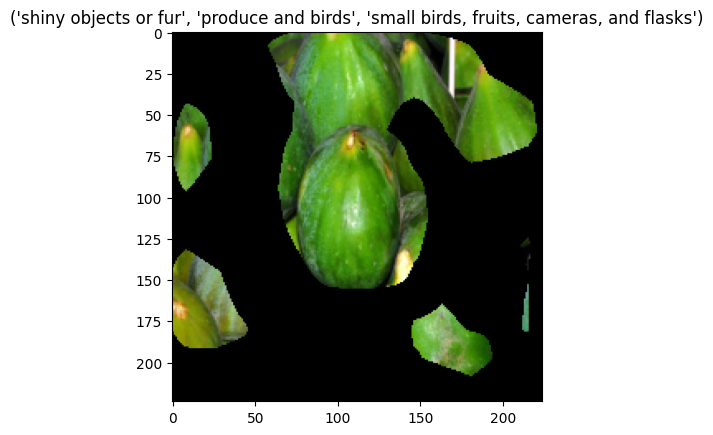

In [158]:
import matplotlib.pyplot as plt
masked_image = sample.masks * sample.images

fig, ax = plt.subplots()
ax.imshow(masked_image[1].permute(1, 2, 0))
ax.set_title(sample.annotations)

In [147]:
sample = dataset.lookup('conv5', 0)

AnnotatedTopImages(layer='conv5', unit=0, images=tensor([[[[0.2235, 0.2078, 0.1765,  ..., 0.6863, 0.5176, 0.2549],
          [0.2157, 0.1961, 0.1922,  ..., 0.6588, 0.6314, 0.2549],
          [0.1843, 0.2157, 0.2392,  ..., 0.4784, 0.6902, 0.2431],
          ...,
          [0.5647, 0.6118, 0.6863,  ..., 0.2000, 0.2627, 0.5098],
          [0.5686, 0.5373, 0.6118,  ..., 0.3529, 0.2902, 0.4941],
          [0.5725, 0.5412, 0.5725,  ..., 0.3961, 0.3569, 0.4510]],

         [[0.4196, 0.4157, 0.3647,  ..., 0.6471, 0.4706, 0.2588],
          [0.3843, 0.3843, 0.3804,  ..., 0.6745, 0.5804, 0.3020],
          [0.3647, 0.3765, 0.4314,  ..., 0.5333, 0.6235, 0.2902],
          ...,
          [0.3569, 0.3922, 0.4588,  ..., 0.1255, 0.2314, 0.4118],
          [0.3255, 0.3255, 0.4235,  ..., 0.2706, 0.2275, 0.3843],
          [0.3373, 0.3020, 0.4392,  ..., 0.2824, 0.2784, 0.3020]],

         [[0.1882, 0.1529, 0.1176,  ..., 0.5216, 0.3176, 0.0824],
          [0.1255, 0.1294, 0.1529,  ..., 0.4980, 0.4235, 0.